# 라이브러리

In [2]:
import pandas as pd
import numpy as np
import pandas_profiling 
#데이터에 대한 overview를 제공해주는 Pandas Profiling이라는 라이브러리
import re
import seaborn as sns
sns.set(style = 'white')
import matplotlib.pyplot as plt
from xgboost import plot_importance
%matplotlib inline
import matplotlib.ticker as mtick # For specifying the axes tick format 
import shap
import eli5
from eli5.sklearn import PermutationImportance
from matplotlib.pyplot import figure

from warnings import warn
import warnings
warnings.filterwarnings('ignore') # warnings를 무시하는 모듈
import warnings
warnings.filterwarnings(action='ignore')

    # Label Encoding
from sklearn.preprocessing import LabelEncoder

    # modeling
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, KFold
from lightgbm import LGBMClassifier

from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import make_scorer, recall_score, log_loss
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import RocCurveDisplay

from scipy.special import softmax

import tensorflow as tf

from lightgbm import LGBMClassifier



C:\Users\Playdata\AppData\Local\Temp\ipykernel_25464\1006639370.py:3: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


In [3]:
# pip install eli5

# 1. Data Prep

#### Data Prep

In [4]:
prc = pd.read_csv('./모델링시작.csv', encoding = 'euc-kr')
# prc.profile_report()

In [5]:
prc = prc[prc['customer_status']!= 'Joined']

prc['churn'] = 0

prc.loc[(prc['customer_status'] == 'Stayed'), 'churn'] = 'No'
prc.loc[(prc['customer_status'] == 'Churned'), 'churn'] = 'Yes'

prc['churn'] = prc['churn'].map({'No': 1, 'Yes': 0})

prc = prc.drop(['customer_status'], axis = 1)

In [6]:
len(prc.columns)

31

#### Split data

In [7]:
X = prc.drop(['churn'], axis = 1)
y = prc['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3, stratify = y)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(4612, 30) (1977, 30)
(4612,) (1977,)


#### Standardization Processing

In [8]:
# 금액 컬럼 표준화
col = ['tenure_in_months', 'avg_monthly_long_distance_charges', 'monthly_charge', 'total_charges',
       'total_extra_data_charges', 'total_long_distance_charges',
       'total_revenue']

from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(X_train[col])

X_train[col] = ss.transform(X_train[col])
X_test[col] = ss.transform(X_test[col]) 

In [9]:
prc.to_csv('ft_imp.csv')

# 2. Building Models without optimization - 순수한 상태

In [10]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(tree_method = 'hist'),
    'LightGBM': LGBMClassifier(),
    'Stacking': StackingClassifier(estimators=[('lr', LogisticRegression()),
                                               ('rf', RandomForestClassifier()), 
                                               ('gb', GradientBoostingClassifier())]),
    'Bagging': BaggingClassifier(base_estimator=RandomForestClassifier(), n_estimators=10),
    'Voting': VotingClassifier(estimators=[('lr', LogisticRegression()),
                                           ('rf', RandomForestClassifier()), 
                                           ('gb', GradientBoostingClassifier())])
}

## Without Cross Validation

In [11]:
# Fit and evaluate models

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy = round(accuracy.mean(), 2)
    
    print(f'{model_name}:')
    print(f'Accuracy: {accuracy}')
    print(classification_report(y_test, y_pred))
    print()

# Voting
# Stacking
# GradientBoosting

Logistic Regression:
Accuracy: 0.84
              precision    recall  f1-score   support

           0       0.71      0.76      0.73       561
           1       0.90      0.88      0.89      1416

    accuracy                           0.84      1977
   macro avg       0.81      0.82      0.81      1977
weighted avg       0.85      0.84      0.85      1977


Decision Tree:
Accuracy: 0.82
              precision    recall  f1-score   support

           0       0.69      0.68      0.69       561
           1       0.88      0.88      0.88      1416

    accuracy                           0.82      1977
   macro avg       0.78      0.78      0.78      1977
weighted avg       0.82      0.82      0.82      1977


Random Forest:
Accuracy: 0.86
              precision    recall  f1-score   support

           0       0.82      0.67      0.74       561
           1       0.88      0.94      0.91      1416

    accuracy                           0.86      1977
   macro avg       0.85      0

## Adding K-fold 

In [12]:
model_names = [] # 각 모델 이름 리스트
acc_results = [] # 검증세트 정확도 점수 저장할 리스트 생성
auc_results = []
pre_results = []
rec_results = []
f1_results = []

result_col = ["Algorithm", "Accuracy", "ROC AUC", "Precision", "Recall", "f1 Score"] # 데이터 프레임 칼럼 리스트
model_results = pd.DataFrame(columns = result_col) # 데이터 프레임 생성, 칼럼은 상위 칼럼 리스트

# Perform K-fold cross-validation
i=0
for model_name, model in models.items():
    model_names.append(model_name)
    kf = KFold(n_splits = 5)
    
    cv_acc_results = model_selection.cross_val_score(model, X_train, y_train, cv = kf, scoring = 'accuracy')
    cv_auc_results = model_selection.cross_val_score(model, X_train, y_train, cv = kf, scoring = 'roc_auc')
    cv_pre_results = model_selection.cross_val_score(model, X_train, y_train, cv = kf, scoring = 'precision')
    cv_rec_results = model_selection.cross_val_score(model, X_train, y_train, cv = kf, scoring = 'recall')
    cv_f1_results = model_selection.cross_val_score(model, X_train, y_train, cv = kf, scoring = 'f1')

    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    pre_results.append(cv_pre_results)
    rec_results.append(cv_rec_results)
    f1_results.append(cv_f1_results)
    
    model_results.loc[i] = [model_name,
                            np.mean(acc_results),
                            np.mean(auc_results),
                            np.mean(pre_results),
                            np.mean(rec_results),
                            np.mean(f1_results)]

    i+=1

model_results.sort_values(by = ['ROC AUC'], ascending=False)


,Algorithm,Accuracy,ROC AUC,Precision,Recall,f1 Score
0,Logistic Regression,0.843668,0.908066,0.889634,0.892577,0.891004
7,Bagging,0.854698,0.902146,0.883763,0.919472,0.900583
6,Stacking,0.853517,0.899655,0.885061,0.915607,0.899432
5,LightGBM,0.850461,0.894565,0.883633,0.912575,0.897194
4,XGBoost,0.848046,0.888721,0.882908,0.909909,0.895410
3,Gradient Boosting,0.845835,0.881663,0.882714,0.906964,0.893708
2,Random Forest,0.836655,0.865272,0.879771,0.896703,0.886995
1,Decision Tree,0.825019,0.840217,0.880665,0.874090,0.876622
8,Voting,0.856435,NaN,0.884541,0.921129,0.901904


# 3. Tuning the parameters on each models

In [13]:
# build model
def build_model(X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    auc_train = roc_auc_score(pred_train, y_train)
    auc_test = roc_auc_score(pred_test, y_test)
    # acc_train = accuracy_score(pred_train, y_train) # 훈련 세트 예측과 훈련 세트 실제 타겟 간의 정확도 확인
    # acc_test = accuracy_score(pred_test, y_test) # 테스트 세트 예측과 테스트 세트 실제 타겟 간의 정확도 확인
    
    print(f'Training roc_auc score {auc_train: .3f}') 
    print(f'Testing roc_auc score {auc_test: .3f}')

In [14]:
# tune parameters
def tuning_params(X, y, params, model):
    gs_acc = GridSearchCV(model, params, scoring = 'accuracy', cv = 5, n_jobs = -1)
    gs_auc = GridSearchCV(model, params, scoring = 'roc_auc', cv = 5, n_jobs = -1)
    
    gs_acc.fit(X, y)
    gs_auc.fit(X, y)
    
    print('Accuracy')
    print('Train score:', gs_acc.score(X_train, y_train))
    print('Best params:', gs_acc.best_params_)
    print("Best estimator: ", gs_acc.best_estimator_)
    print("Best score: ", gs_acc.best_score_)
    
    print('\nROC_AUC')
    print('Train score:', gs_auc.score(X_train, y_train))
    print('Best params:', gs_auc.best_params_)
    print("Best estimator: ", gs_auc.best_estimator_)
    print("Best score: ", gs_auc.best_score_)
    
    return gs_acc.best_estimator_, gs_auc.best_estimator_

In [15]:
# evaluating
def good_eval(X_train, X_test, y_train, y_test, goodmodel):
    goodmodel.fit(X_train, y_train)
    
    pred_goodmodel = goodmodel.predict(X_test)
    
    print('Results on test data: ')

    acc_ = accuracy_score(y_test, pred_goodmodel)
    pre_ = precision_score(y_test, pred_goodmodel)
    rec_ = recall_score(y_test, pred_goodmodel)
    auc_ = roc_auc_score(y_test, pred_goodmodel)

    print(f'Test accuracy = {acc_: .4f}') 
    print(f'Test precision = {pre_: .4f}') 
    print(f'Test recall = {rec_: .4f}') 
    print(f'Test auc = {auc_: .4f}')

    print("Classification report:")
    print(classification_report(y_test, pred_goodmodel))

    print("Confusion matrix (Rows actual, Columns predicted):")
    print(pd.DataFrame(confusion_matrix(y_test, pred_goodmodel)))

In [16]:
# roc plot
def roc_plot(model, X, y):
    print("ROC curve plot:")
    fig = plt.figure(figsize=(6,6))
    fig.set_facecolor('white')
    RocCurveDisplay.from_estimator(model, X, y)
    # ax.plot([0, 1], [0, 1], color='red', label='Random Model')
    plt.legend()
    plt.show()

## 3-1. Logistic Regression

#### Build model

In [17]:
lr = LogisticRegression(random_state = 42)
build_model(X_train, X_test, y_train, y_test, lr)

Training roc_auc score  0.815
Testing roc_auc score  0.807


#### Tuning the parameters
- ROC_AUC
- Train score: 0.9193008567133898
- Best params: {'C': 10, 'max_iter': 1100}
- Best estimator:  LogisticRegression(C=10, max_iter=1100, random_state=42)
- Best score:  0.9156866760019613

In [18]:
param1 = {'C':[10, 100, 1000], 'max_iter': [100, 300, 500, 700, 900, 1100]}
tuning_params(X_train, y_train, params = param1, model = lr)

Accuracy
Train score: 0.8566782307025151
Best params: {'C': 1000, 'max_iter': 1100}
Best estimator:  LogisticRegression(C=1000, max_iter=1100, random_state=42)
Best score:  0.8545131291671269

ROC_AUC
Train score: 0.9192383803155846
Best params: {'C': 10, 'max_iter': 500}
Best estimator:  LogisticRegression(C=10, max_iter=500, random_state=42)
Best score:  0.9157490609084586


(LogisticRegression(C=1000, max_iter=1100, random_state=42),
 LogisticRegression(C=10, max_iter=500, random_state=42))

#### Evaluating

Results on test data: 
Test accuracy =  0.8548
Test precision =  0.9047
Test recall =  0.8912
Test auc =  0.8271
Classification report:
              precision    recall  f1-score   support

           0       0.74      0.76      0.75       561
           1       0.90      0.89      0.90      1416

    accuracy                           0.85      1977
   macro avg       0.82      0.83      0.82      1977
weighted avg       0.86      0.85      0.86      1977

Confusion matrix (Rows actual, Columns predicted):
     0     1
0  428   133
1  154  1262
ROC curve plot:


<Figure size 600x600 with 0 Axes>

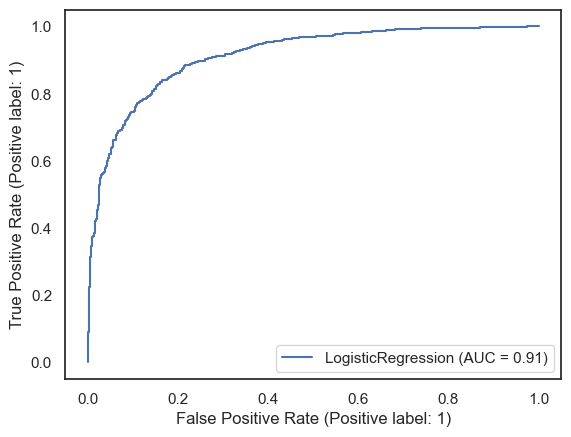

In [19]:
good_lr = LogisticRegression(C = 10, max_iter = 1100, random_state = 42)
good_eval(X_train, X_test, y_train, y_test, goodmodel = good_lr)
roc_plot(model = good_lr, X = X_test, y = y_test)

## 3-2. Bagging

#### build model

In [20]:
# 순정
naive_bag = BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42), 
                        random_state = 42, n_jobs = -1)
build_model(X_train, X_test, y_train, y_test, model = naive_bag)

Training roc_auc score  0.979
Testing roc_auc score  0.863


#### Tuning the parameters
- randomforest 순정상태 <br>
ROC_AUC <br>
Train score: 0.987582006056971 <br>
Best params: {'max_samples': 2000, 'n_estimators': 200, 'oob_score': True} <br>
Best estimator:  BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42),
                  max_samples=2000, n_estimators=200, n_jobs=-1, oob_score=True,
                  random_state=42) <br>
Best score:  0.9198890065424496 <br>
- 노순정 <br>
ROC_AUC <br>
Train score: 0.938705100295444 <br>
Best params: {'max_samples': 2000, 'n_estimators': 200, 'oob_score': True} <br>
Best estimator:  BaggingClassifier(base_estimator=RandomForestClassifier(max_features=25,
                                                        max_leaf_nodes=24,
                                                        n_estimators=75,
                                                        random_state=42),
                  max_samples=2000, n_estimators=200, n_jobs=-1, oob_score=True,
                  random_state=42) <br>
Best score:  0.9196128229444724 <br>


In [21]:
param1 = [{'n_estimators': [100, 150, 200], 'max_samples': [1000, 2000], 'oob_score': [True, False],
          }]
tuning_params(X_train, y_train, params = param1, model = naive_bag)

Accuracy
Train score: 0.901561144839549
Best params: {'max_samples': 1000, 'n_estimators': 100, 'oob_score': True}
Best estimator:  BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42),
                  max_samples=1000, n_estimators=100, n_jobs=-1, oob_score=True,
                  random_state=42)
Best score:  0.8644843867140773

ROC_AUC
Train score: 0.987582006056971
Best params: {'max_samples': 2000, 'n_estimators': 200, 'oob_score': True}
Best estimator:  BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42),
                  max_samples=2000, n_estimators=200, n_jobs=-1, oob_score=True,
                  random_state=42)
Best score:  0.9198890065424496


(BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42),
                   max_samples=1000, n_estimators=100, n_jobs=-1, oob_score=True,
                   random_state=42),
 BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42),
                   max_samples=2000, n_estimators=200, n_jobs=-1, oob_score=True,
                   random_state=42))

#### Evaluating

Results on test data: 
Test accuracy =  0.8741
Test precision =  0.8821
Test recall =  0.9513
Test auc =  0.8152
Classification report:
              precision    recall  f1-score   support

           0       0.85      0.68      0.75       561
           1       0.88      0.95      0.92      1416

    accuracy                           0.87      1977
   macro avg       0.86      0.82      0.83      1977
weighted avg       0.87      0.87      0.87      1977

Confusion matrix (Rows actual, Columns predicted):
     0     1
0  381   180
1   69  1347
ROC curve plot:


<Figure size 600x600 with 0 Axes>

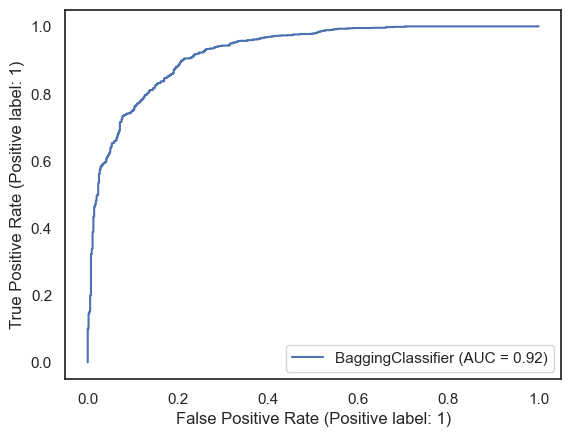

In [22]:
good_nbag = BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42), 
                             max_samples=2000, n_estimators=200, n_jobs=-1, oob_score=True, random_state=42)
good_eval(X_train, X_test, y_train, y_test, goodmodel = good_nbag)
roc_plot(model = good_nbag, X = X_test, y = y_test)

## 3-3. Random Forest

#### Build model

In [23]:
rf = RandomForestClassifier(random_state = 42)
build_model(X_train, X_test, y_train, y_test, rf)

Training roc_auc score  1.000
Testing roc_auc score  0.863


#### Tuning the parameters

In [24]:
param1 = [{'n_estimators': [25, 50, 75],
           'max_features': [15, 20, 25],
           'max_leaf_nodes': [8, 16, 24]}]
tuning_params(X_train, y_train, params = param1, model = rf)

Accuracy
Train score: 0.8848655680832611
Best params: {'max_features': 15, 'max_leaf_nodes': 24, 'n_estimators': 50}
Best estimator:  RandomForestClassifier(max_features=15, max_leaf_nodes=24, n_estimators=50,
                       random_state=42)
Best score:  0.8696890503709727

ROC_AUC
Train score: 0.9381844636470665
Best params: {'max_features': 15, 'max_leaf_nodes': 24, 'n_estimators': 50}
Best estimator:  RandomForestClassifier(max_features=15, max_leaf_nodes=24, n_estimators=50,
                       random_state=42)
Best score:  0.9226447143923714


(RandomForestClassifier(max_features=15, max_leaf_nodes=24, n_estimators=50,
                        random_state=42),
 RandomForestClassifier(max_features=15, max_leaf_nodes=24, n_estimators=50,
                        random_state=42))

#### Evaluating

Results on test data: 
Test accuracy =  0.8730
Test precision =  0.8825
Test recall =  0.9492
Test auc =  0.8150
Classification report:
              precision    recall  f1-score   support

           0       0.84      0.68      0.75       561
           1       0.88      0.95      0.91      1416

    accuracy                           0.87      1977
   macro avg       0.86      0.82      0.83      1977
weighted avg       0.87      0.87      0.87      1977

Confusion matrix (Rows actual, Columns predicted):
     0     1
0  382   179
1   72  1344
ROC curve plot:


<Figure size 600x600 with 0 Axes>

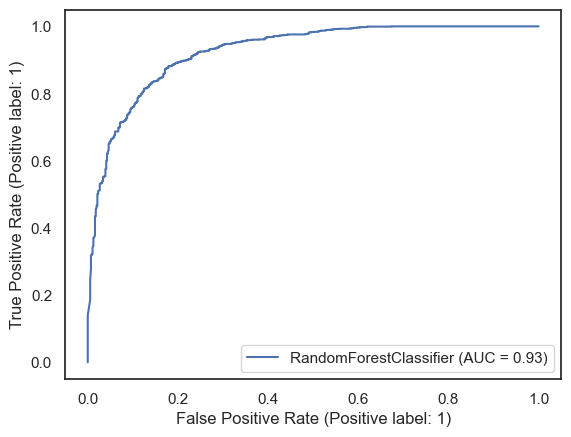

In [25]:
good_rf = RandomForestClassifier(max_features=15, max_leaf_nodes=24, n_estimators=50, random_state=42)
good_eval(X_train, X_test, y_train, y_test, goodmodel = good_rf)
roc_plot(model = good_rf, X = X_test, y = y_test)

#### Feature importance
- prc

<AxesSubplot: >

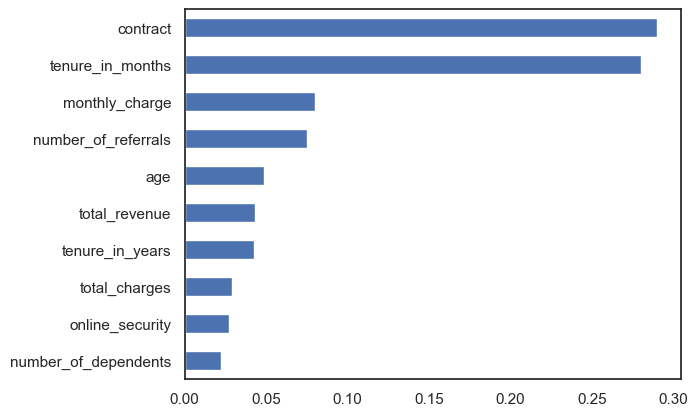

In [26]:
importances = good_rf.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh')

## 3-4. Gradient Boosting

#### Building model

In [27]:
gb = GradientBoostingClassifier(random_state = 42)
build_model(X_train, X_test, y_train, y_test, model = gb)

Training roc_auc score  0.893
Testing roc_auc score  0.864


#### Tuning the parameter

In [28]:
param1 = [{'n_estimators': [80, 100, 150, 200, 500],
         'learning_rate': [0.1, 0.2, 0.3],
         'max_depth': [1, 3, 5, 7, 9]}]
tuning_params(X_train, y_train, params = param1, model = gb)

Accuracy
Train score: 0.9095836947094535
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}
Best estimator:  GradientBoostingClassifier(n_estimators=150, random_state=42)
Best score:  0.8761940573861994

ROC_AUC
Train score: 0.964728139739802
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}
Best estimator:  GradientBoostingClassifier(n_estimators=150, random_state=42)
Best score:  0.9314197879523952


(GradientBoostingClassifier(n_estimators=150, random_state=42),
 GradientBoostingClassifier(n_estimators=150, random_state=42))

#### Evaluating

Results on test data: 
Test accuracy =  0.8791
Test precision =  0.8995
Test recall =  0.9357
Test auc =  0.8360
Classification report:
              precision    recall  f1-score   support

           0       0.82      0.74      0.78       561
           1       0.90      0.94      0.92      1416

    accuracy                           0.88      1977
   macro avg       0.86      0.84      0.85      1977
weighted avg       0.88      0.88      0.88      1977

Confusion matrix (Rows actual, Columns predicted):
     0     1
0  413   148
1   91  1325
ROC curve plot:


<Figure size 600x600 with 0 Axes>

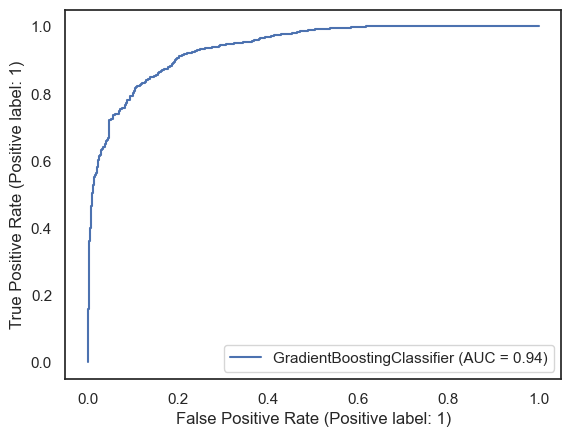

In [29]:
good_gb = GradientBoostingClassifier(n_estimators=150, learning_rate = 0.1, max_depth = 5, random_state=42)
good_eval(X_train, X_test, y_train, y_test, goodmodel = good_gb)
roc_plot(model = good_gb, X = X_test, y = y_test)

### Feature importance

In [30]:
print(good_gb.feature_importances_)

[2.41275367e-03 5.71078133e-02 2.51386190e-03 3.32651138e-02
 8.73047406e-02 2.41437759e-01 6.20773721e-03 8.04211311e-05
 2.24392154e-02 3.37802307e-03 0.00000000e+00 5.26220860e-03
 1.90189499e-02 1.33713088e-02 2.96861576e-03 1.16621685e-03
 7.87716156e-03 2.01389637e-03 2.41944890e-03 4.54426852e-03
 1.38785367e-03 2.91517943e-01 6.38575276e-03 5.80129243e-03
 8.48961889e-02 3.32345144e-02 7.48303072e-03 2.75390808e-02
 2.53529032e-02 1.61192555e-03]


<AxesSubplot: >

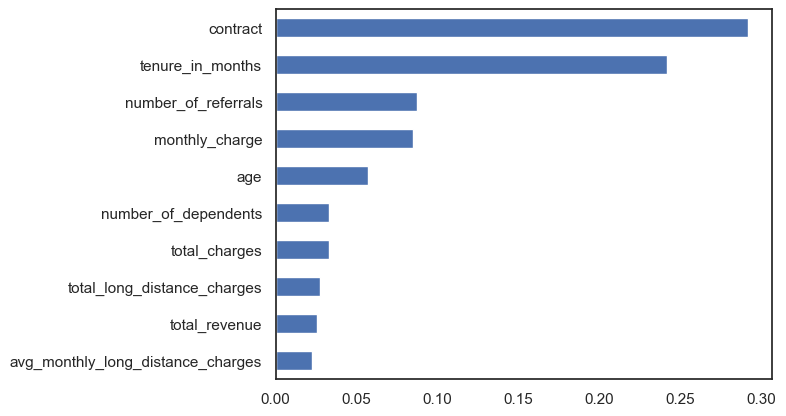

In [31]:
importances = good_gb.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh')

## 3-5. XGBoost

#### Building model

In [32]:
xgb = XGBClassifier(tree_method = 'hist', random_state = 42) # (n_estimators=700, learning_rate=0.1, max_depth=3)
build_model(X_train, X_test, y_train, y_test, model = xgb)

Training roc_auc score  0.998
Testing roc_auc score  0.847


#### Tuning the parameters

In [33]:
param1 = [{'n_estimators': [100, 300, 500, 700],
           'learning_rate': [0.1, 0.2, 0.3],
           'max_depth': [1, 3, 5, 7, 9]}]
tuning_params(X_train, y_train, params = param1, model = xgb)

Accuracy
Train score: 0.8922376409366869
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best estimator:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
Best score:  0.8746763242562332

ROC_AUC
Train score: 0.952233901452044
Best params: {'learning_rate': 0.1, 'max_depth': 3,

(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=3, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=42, ...),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric

#### Evaluating

[0]	validation_0-logloss:0.64216
[1]	validation_0-logloss:0.59941
[2]	validation_0-logloss:0.56471
[3]	validation_0-logloss:0.53479
[4]	validation_0-logloss:0.50877
[5]	validation_0-logloss:0.48701
[6]	validation_0-logloss:0.46773
[7]	validation_0-logloss:0.45152
[8]	validation_0-logloss:0.43624
[9]	validation_0-logloss:0.42335
[10]	validation_0-logloss:0.41183
[11]	validation_0-logloss:0.40092
[12]	validation_0-logloss:0.39186
[13]	validation_0-logloss:0.38308
[14]	validation_0-logloss:0.37512
[15]	validation_0-logloss:0.36832
[16]	validation_0-logloss:0.36213
[17]	validation_0-logloss:0.35658
[18]	validation_0-logloss:0.35136
[19]	validation_0-logloss:0.34401
[20]	validation_0-logloss:0.33939
[21]	validation_0-logloss:0.33570
[22]	validation_0-logloss:0.33222
[23]	validation_0-logloss:0.32889
[24]	validation_0-logloss:0.32351
[25]	validation_0-logloss:0.32106
[26]	validation_0-logloss:0.31834
[27]	validation_0-logloss:0.31611
[28]	validation_0-logloss:0.31417
[29]	validation_0-loglos

<Figure size 600x600 with 0 Axes>

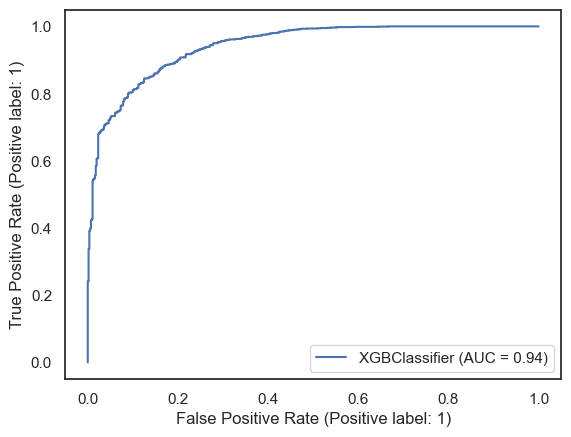

In [34]:
good_xgb = XGBClassifier(tree_method = 'hist', learning_rate = 0.1, max_depth = 3, n_estimators = 100, random_state = 42)

evals = [(X_test, y_test)]
good_xgb.fit(X_train, y_train, 
             early_stopping_rounds = 100, eval_metric="logloss", eval_set = evals, verbose=True)
pred_xgb = good_xgb.predict(X_test)


print('Results on test data: ')

acc_xgb = accuracy_score(y_test, pred_xgb)
pre_xgb = precision_score(y_test, pred_xgb)
rec_xgb = recall_score(y_test, pred_xgb)
auc_xgb = roc_auc_score(y_test, pred_xgb)

print(f'Test accuracy = {acc_xgb: .4f}') 
print(f'Test precision = {pre_xgb: .4f}') 
print(f'Test recall = {rec_xgb: .4f}') 
print(f'Test auc = {auc_xgb: .4f}')

print("Classification report:")
print(classification_report(y_test, pred_xgb))

print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(y_test, pred_xgb)))

roc_plot(model = good_xgb, X = X_test, y = y_test)

## 3-6. Support Vector Machine

In [35]:
svmc = SVC(random_state = 42, probability=True)
build_model(X_train, X_test, y_train, y_test, model=svmc)

Training roc_auc score  0.779
Testing roc_auc score  0.775


#### Evaluating

Results on test data: 
Test accuracy =  0.8548
Test precision =  0.9070
Test recall =  0.8884
Test auc =  0.8292
Classification report:
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       561
           1       0.91      0.89      0.90      1416

    accuracy                           0.85      1977
   macro avg       0.82      0.83      0.82      1977
weighted avg       0.86      0.85      0.86      1977

Confusion matrix (Rows actual, Columns predicted):
     0     1
0  432   129
1  158  1258
ROC curve plot:


<Figure size 600x600 with 0 Axes>

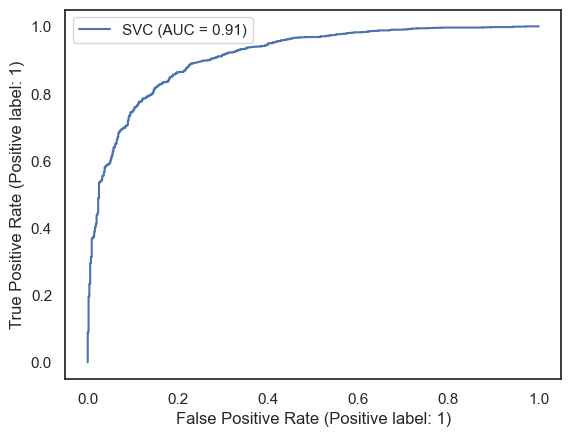

In [36]:
goodsvm = SVC(random_state = 42, probability=True, C = 1, kernel = 'linear', gamma = 0.1)
good_eval(X_train, X_test, y_train, y_test, goodmodel = goodsvm)
roc_plot(model = goodsvm, X = X_test, y = y_test)

## 3-7. Decision Tree

Results on test data: 
Test accuracy =  0.8538
Test precision =  0.8633
Test recall =  0.9456
Test auc =  0.7839
Classification report:
              precision    recall  f1-score   support

           0       0.82      0.62      0.71       561
           1       0.86      0.95      0.90      1416

    accuracy                           0.85      1977
   macro avg       0.84      0.78      0.80      1977
weighted avg       0.85      0.85      0.85      1977

Confusion matrix (Rows actual, Columns predicted):
     0     1
0  349   212
1   77  1339
ROC curve plot:


<Figure size 600x600 with 0 Axes>

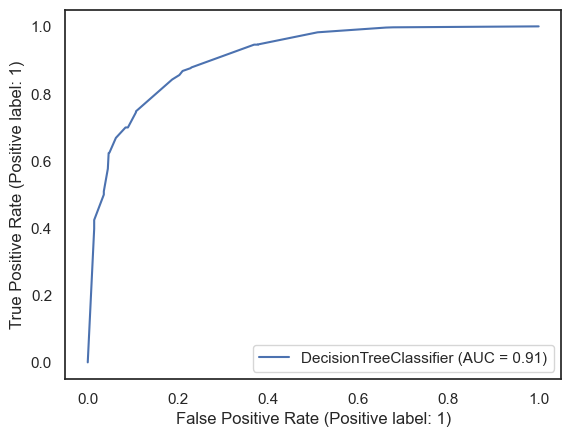

In [37]:
good_dt = DecisionTreeClassifier(criterion='entropy', max_depth=6)

good_eval(X_train, X_test, y_train, y_test, goodmodel = good_dt)
roc_plot(model = good_dt, X = X_test, y = y_test)

<AxesSubplot: >

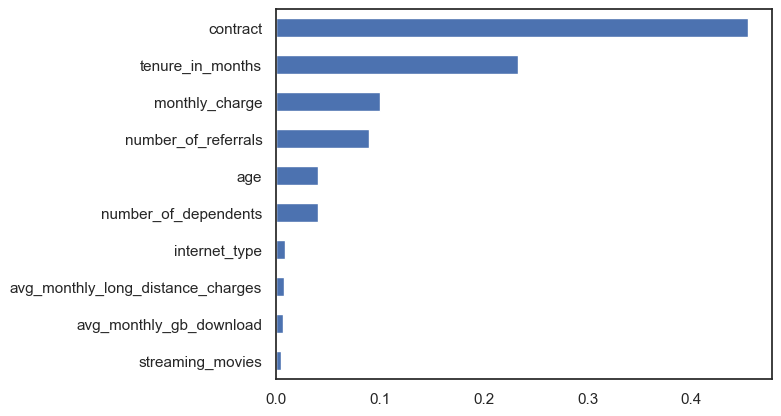

In [38]:
#### Feature Importance
importances = good_dt.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh')

## 3-8. LightGBM

In [39]:
lgbm = LGBMClassifier(random_state = 42)
build_model(X_train, X_test, y_train, y_test, lgbm)

Training roc_auc score  0.973
Testing roc_auc score  0.855


In [40]:
param1 = {'learning_rate': [0.1, 0.2, 0.3],
          'max_depth': [1, 3, 5, 7, 9],
          'n_estimators': [100, 300, 500, 700]}
tuning_params(X_train, y_train, params = param1, model = lgbm)

Accuracy
Train score: 0.8941890719861232
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best estimator:  LGBMClassifier(max_depth=3, random_state=42)
Best score:  0.8738098203772946

ROC_AUC
Train score: 0.9532204500522024
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best estimator:  LGBMClassifier(max_depth=3, random_state=42)
Best score:  0.9325897763661603


(LGBMClassifier(max_depth=3, random_state=42),
 LGBMClassifier(max_depth=3, random_state=42))

Results on test data: 
Test accuracy =  0.8811
Test precision =  0.8987
Test recall =  0.9400
Test auc =  0.8363
Classification report:
              precision    recall  f1-score   support

           0       0.83      0.73      0.78       561
           1       0.90      0.94      0.92      1416

    accuracy                           0.88      1977
   macro avg       0.86      0.84      0.85      1977
weighted avg       0.88      0.88      0.88      1977

Confusion matrix (Rows actual, Columns predicted):
     0     1
0  411   150
1   85  1331
ROC curve plot:


<Figure size 600x600 with 0 Axes>

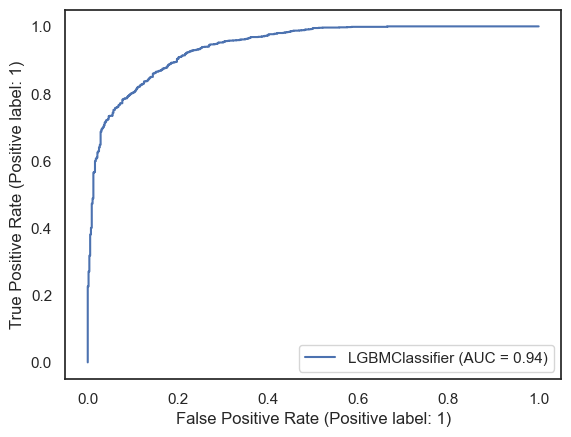

In [41]:
good_lgbm = LGBMClassifier(learning_rate = 0.1, max_depth = 3, n_estimators = 100, random_state = 42)
good_eval(X_train, X_test, y_train, y_test, goodmodel = good_lgbm)
roc_plot(model = good_lgbm, X = X_test, y = y_test)

# 4. Finding good model (테스트 세트)

In [42]:
models = {
    'Logistic Regression': LogisticRegression(C = 10, max_iter = 900, random_state = 42),
    'Decision Tree': DecisionTreeClassifier(criterion='entropy', max_depth=6),
    'Random Forest': RandomForestClassifier(max_features=25, max_leaf_nodes=24, n_estimators=75, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators = 300, learning_rate = 0.1, max_depth = 5, random_state = 42),
    'XGBoost': XGBClassifier(tree_method = 'hist', learning_rate = 0.1, max_depth = 3, n_estimators = 500, random_state = 42),
    'LightGBM': LGBMClassifier(learning_rate = 0.1, max_depth = 3, n_estimators = 100, random_state = 42),
    'Support Vector Machine': SVC(random_state = 42, probability=True, C = 1, kernel = 'linear', gamma = 0.1),
    # 'Stacking': StackingClassifier(estimators=[('lr', LogisticRegression()),
    #                                            ('rf', RandomForestClassifier()), 
    #                                            ('gb', GradientBoostingClassifier())]),
    'Bagging': BaggingClassifier(base_estimator=RandomForestClassifier(), 
                        n_estimators=10, oob_score = True, bootstrap = True, random_state = 42, n_jobs = -1),
    # 'AdaBoost': AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50),
    # 'Voting': VotingClassifier(estimators=[('lr', LogisticRegression()),
    #                                        ('rf', RandomForestClassifier()), 
    #                                        ('gb', GradientBoostingClassifier())])
}

In [43]:
model_names_opt = [] # 각 모델 이름 리스트
acc_opt = [] # 검증세트 정확도 점수 저장할 리스트 생성
auc_opt = []
pre_opt = []
rec_opt = []
f1_opt = []

result_col_opt = ["Algorithm", "ROC AUC", "Accuracy", "Precision", "Recall", "f1 Score"] # 데이터 프레임 칼럼 리스트
results_opt = pd.DataFrame(columns = result_col_opt) # 데이터 프레임 생성, 칼럼은 상위 칼럼 리스트


i=0
for model_name, model in models.items():
    model_names_opt.append(model_name)
    kf = KFold(n_splits = 5)
    
    acc_results_opt = model_selection.cross_val_score(model, X_train, y_train, cv = kf, scoring = 'accuracy')
    auc_results_opt = model_selection.cross_val_score(model, X_train, y_train, cv = kf, scoring = 'roc_auc')
    pre_results_opt = model_selection.cross_val_score(model, X_train, y_train, cv = kf, scoring = 'precision')
    rec_results_opt = model_selection.cross_val_score(model, X_train, y_train, cv = kf, scoring = 'recall')
    f1_results_opt = model_selection.cross_val_score(model, X_train, y_train, cv = kf, scoring = 'f1')

    acc_opt.append(acc_results_opt)
    auc_opt.append(auc_results_opt)
    pre_opt.append(pre_results_opt)
    rec_opt.append(rec_results_opt)
    f1_opt.append(f1_results_opt)
    
    results_opt.loc[i] = [model_name,
                            np.mean(auc_results_opt),
                            np.mean(acc_results_opt),
                            np.mean(pre_results_opt),
                            np.mean(rec_results_opt),
                            np.mean(f1_results_opt)]

    i+=1

results_opt.sort_values(by = ['ROC AUC'], ascending=False)


,Algorithm,ROC AUC,Accuracy,Precision,Recall,f1 Score
5,LightGBM,0.931332,0.872506,0.889832,0.938324,0.913383
3,Gradient Boosting,0.924463,0.865132,0.886176,0.931299,0.908143
4,XGBoost,0.923786,0.862965,0.889300,0.923811,0.906188
2,Random Forest,0.921244,0.868602,0.876868,0.950169,0.911984
7,Bagging,0.919099,0.863397,0.871215,0.949816,0.908754
0,Logistic Regression,0.915451,0.852994,0.896526,0.898761,0.897492
6,Support Vector Machine,0.915159,0.849523,0.897260,0.892333,0.894645
1,Decision Tree,0.906021,0.855594,0.859344,0.954552,0.904601


In [44]:
model_names_opt = [] # 각 모델 이름 리스트
acc_opt = [] # 검증세트 정확도 점수 저장할 리스트 생성
auc_opt = []
pre_opt = []
rec_opt = []
f1_opt = []

result_col_opt = ["Algorithm", "ROC AUC", "Accuracy", "Precision", "Recall", "f1 Score"] # 데이터 프레임 칼럼 리스트
results_opt = pd.DataFrame(columns = result_col_opt) # 데이터 프레임 생성, 칼럼은 상위 칼럼 리스트


i=0
for model_name, model in models.items():
    model_names_opt.append(model_name)
    kf = KFold(n_splits = 5)
    
    acc_results_opt = model_selection.cross_val_score(model, X_test, y_test, cv = kf, scoring = 'accuracy')
    auc_results_opt = model_selection.cross_val_score(model, X_test, y_test, cv = kf, scoring = 'roc_auc')
    pre_results_opt = model_selection.cross_val_score(model, X_test, y_test, cv = kf, scoring = 'precision')
    rec_results_opt = model_selection.cross_val_score(model, X_test, y_test, cv = kf, scoring = 'recall')
    f1_results_opt = model_selection.cross_val_score(model, X_test, y_test, cv = kf, scoring = 'f1')

    acc_opt.append(acc_results_opt)
    auc_opt.append(auc_results_opt)
    pre_opt.append(pre_results_opt)
    rec_opt.append(rec_results_opt)
    f1_opt.append(f1_results_opt)
    
    results_opt.loc[i] = [model_name,
                            np.mean(auc_results_opt),
                            np.mean(acc_results_opt),
                            np.mean(pre_results_opt),
                            np.mean(rec_results_opt),
                            np.mean(f1_results_opt)]

    i+=1

results_opt.sort_values(by = ['ROC AUC'], ascending=False)


,Algorithm,ROC AUC,Accuracy,Precision,Recall,f1 Score
5,LightGBM,0.933857,0.881634,0.896296,0.944263,0.919468
4,XGBoost,0.927518,0.871522,0.895846,0.928727,0.911834
2,Random Forest,0.925297,0.869994,0.876209,0.953397,0.913045
3,Gradient Boosting,0.925282,0.871519,0.892156,0.933499,0.912153
7,Bagging,0.916867,0.871004,0.873792,0.958391,0.914043
0,Logistic Regression,0.907543,0.845210,0.890648,0.894080,0.892116
6,Support Vector Machine,0.906696,0.843180,0.887990,0.893947,0.890867
1,Decision Tree,0.894625,0.841158,0.872625,0.911991,0.891493


# 5-1. ROC Curve

### As one

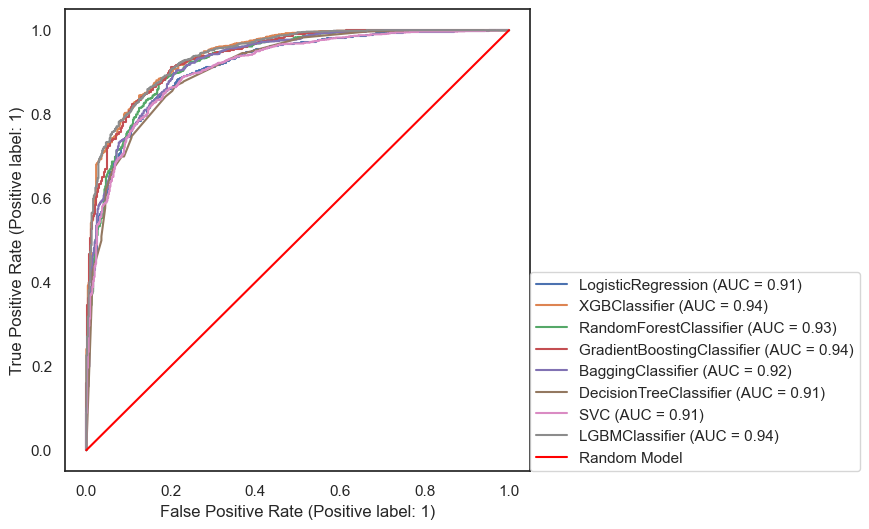

In [45]:
# roc plot

fig = plt.figure(figsize=(6,6))
fig.set_facecolor('white')
ax = fig.add_subplot()
RocCurveDisplay.from_estimator(good_lr, X_test, y_test, ax=ax)
RocCurveDisplay.from_estimator(good_xgb, X_test, y_test, ax=ax)
RocCurveDisplay.from_estimator(good_rf, X_test, y_test, ax=ax)
RocCurveDisplay.from_estimator(good_gb, X_test, y_test, ax=ax)
RocCurveDisplay.from_estimator(good_nbag, X_test, y_test, ax=ax)
RocCurveDisplay.from_estimator(good_dt, X_test, y_test, ax=ax)
RocCurveDisplay.from_estimator(goodsvm, X_test, y_test, ax=ax)
RocCurveDisplay.from_estimator(good_lgbm, X_test, y_test, ax=ax)
ax.plot([0, 1], [0, 1], color='red', label='Random Model')
ax.legend(loc = [1.0, 0])
plt.show()

### Individually

<Figure size 600x600 with 0 Axes>

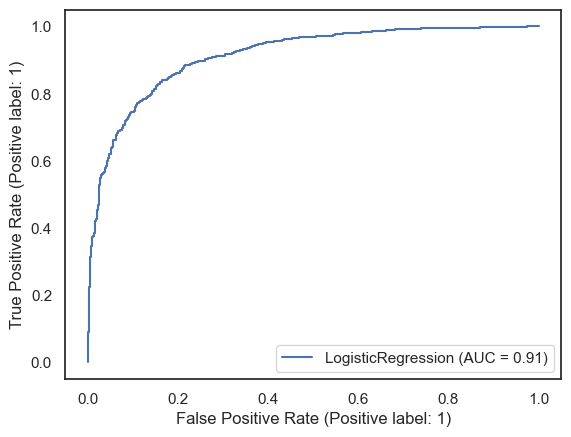

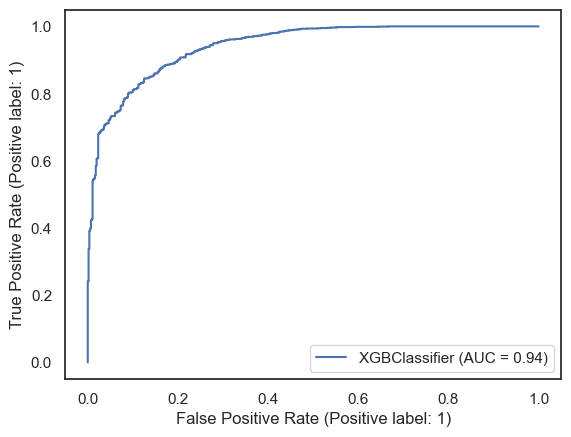

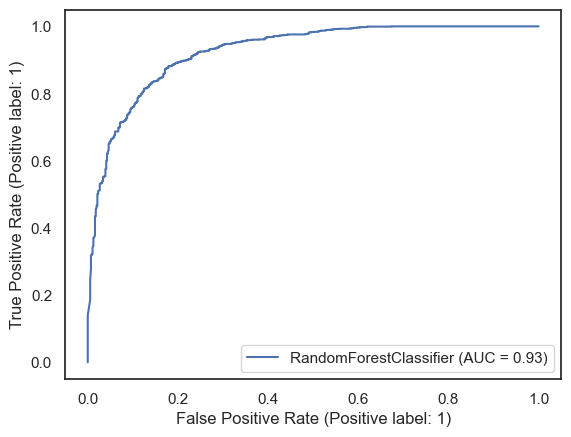

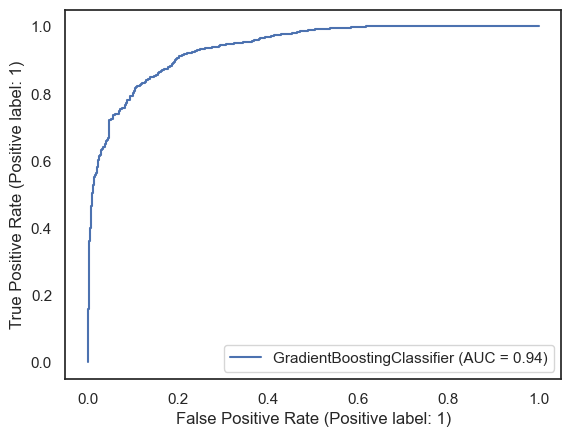

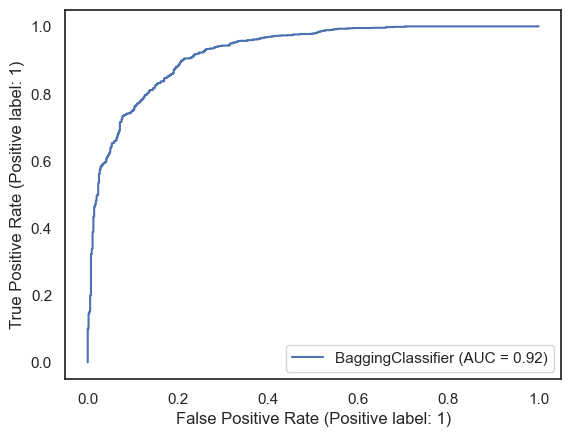

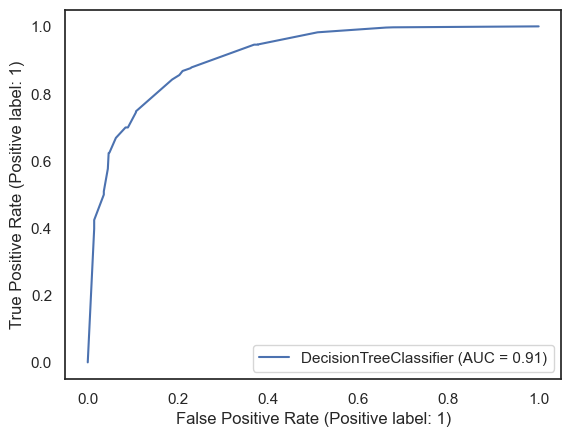

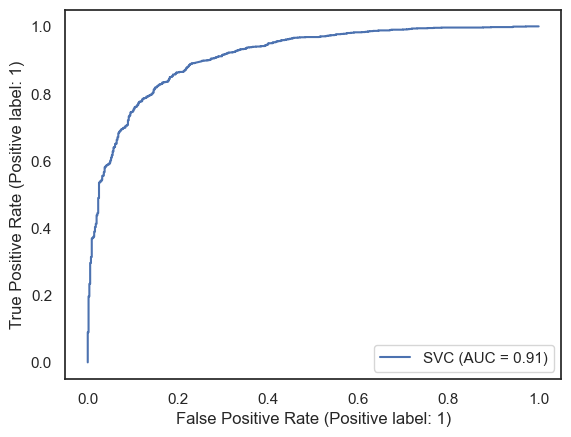

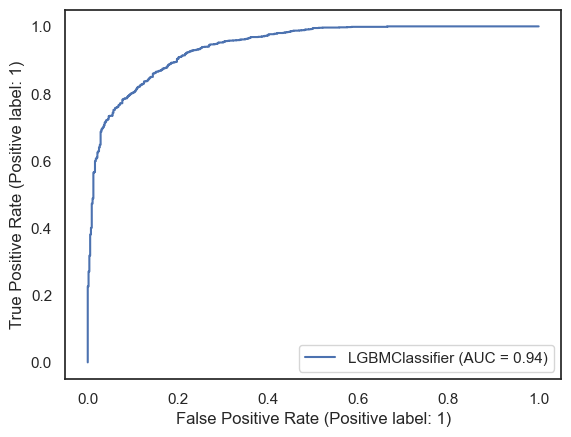

In [46]:
# roc plot

fig = plt.figure(figsize=(6,6))
fig.set_facecolor('white')
RocCurveDisplay.from_estimator(good_lr, X_test, y_test)
RocCurveDisplay.from_estimator(good_xgb, X_test, y_test)
RocCurveDisplay.from_estimator(good_rf, X_test, y_test)
RocCurveDisplay.from_estimator(good_gb, X_test, y_test)
RocCurveDisplay.from_estimator(good_nbag, X_test, y_test)
RocCurveDisplay.from_estimator(good_dt, X_test, y_test)
RocCurveDisplay.from_estimator(goodsvm, X_test, y_test)
RocCurveDisplay.from_estimator(good_lgbm, X_test, y_test)
ax.plot([0, 1], [0, 1], color='red', label='Random Model')
plt.legend()
plt.show()

##### memo

# 5. SHAP for feature importance
**Permutation Importance** <br>
- 모델 재학습 시킬 필요 없음
- 특성 제거 대신 특정 특성을 permutate 해서 노이즈로 만듦
- permutating particular features to explore the differences between predicted values and real values and moreover the effect of the relevant features.
- if trained model are too dependent on the relevant features, then predict-accuracy would greatly decrease.
    - in other words, lower performance & crucial features
- each feature importance != partial importance
    - each feature importance includes the relation/ interactions with other features

Interpreting Permutation Importances
- The first number in each row shows how much model performance decreased with a random shuffling (in this case, using "accuracy" as the performance metric).
- The number after the ± measures how performance varied from one-reshuffling to the next.
- You'll occasionally see negative values for permutation importances. In those cases, the predictions on the shuffled (or noisy) data happened to be more accurate than the real data. 

## 5-1. Model Evaluating using Feature Importances (Random Forest)

### Permutation Importance

In [47]:
perm = PermutationImportance(good_rf, random_state = 1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0656 ± 0.0110,tenure_in_months
0.0519 ± 0.0073,contract
0.0327 ± 0.0108,monthly_charge
0.0276 ± 0.0101,number_of_referrals
0.0196 ± 0.0045,age
0.0092 ± 0.0029,number_of_dependents
0.0018 ± 0.0030,online_security
0.0015 ± 0.0014,premium_tech_support
0.0015 ± 0.0009,paperless_billing
0.0010 ± 0.0036,total_revenue


### Visualization - Feature Importance

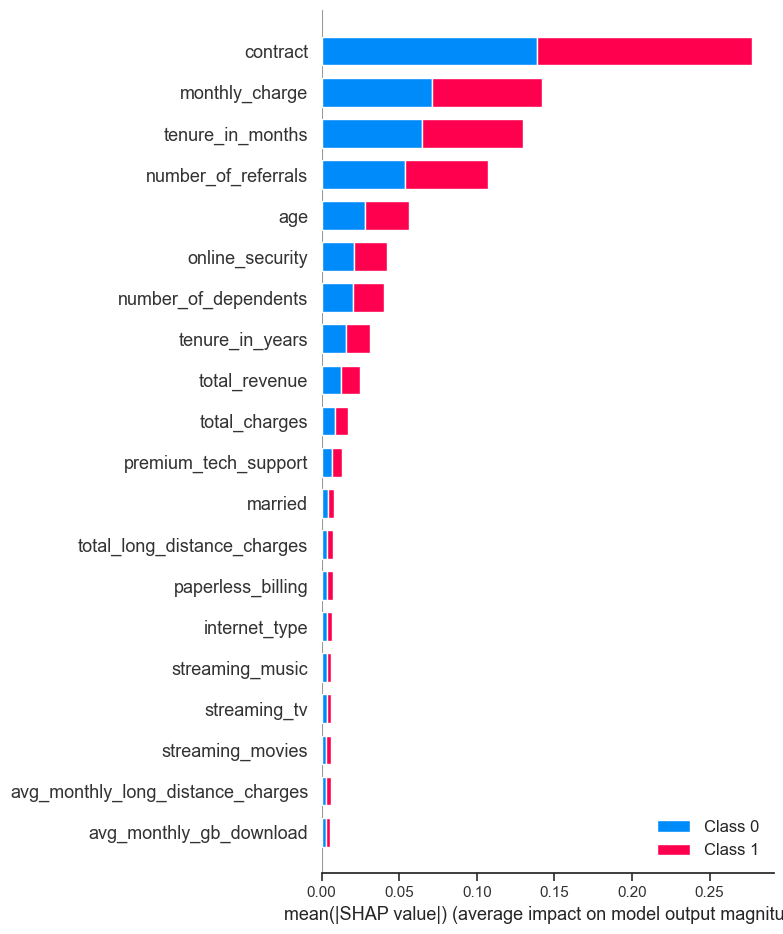

In [48]:
explainer = shap.TreeExplainer(good_rf)
shap_values = explainer.shap_values(X)

plt.figure(figsize=(10, 5))
shap.summary_plot(shap_values, X_train)
plt.show()


### 특성중요도 기준 모델 평가

In [49]:
prc1 = prc.query('monthly_charge >= 0')
X1 = prc1.drop(['churn'], axis=1)
y1 = prc1['churn']
train_X1, val_X1, train_y1, val_y1 = train_test_split(X1, y1, test_size=0.3, random_state=42)
good_modelRF = good_rf.fit(train_X1, train_y1)

Results on test data
Test accuracy =  0.8776
Test precision =  0.8908
Test recall =  0.9449
Test auc =  0.8263
Classification report:
              precision    recall  f1-score   support

           0       0.84      0.71      0.77       561
           1       0.89      0.94      0.92      1416

    accuracy                           0.88      1977
   macro avg       0.86      0.83      0.84      1977
weighted avg       0.88      0.88      0.87      1977

Confusion matrix (Rows actual, Columns predicted):
     0     1
0  397   164
1   78  1338

ROC curve


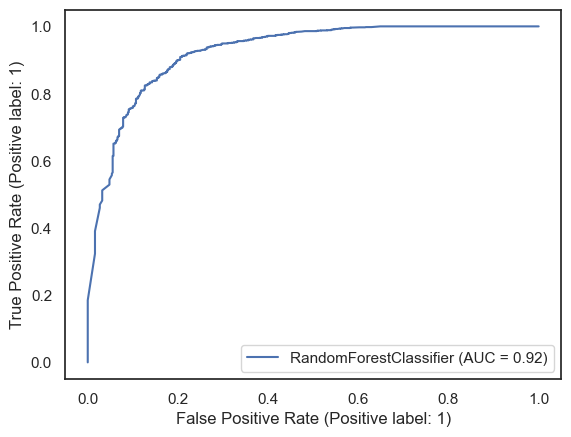

In [50]:
imp_features = ['contract', 'tenure_in_months', 'monthly_charge', 'number_of_referrals', 'age', 'number_of_dependents', 'online_security']
                    # age 부터는 넣나 안넣나 0.92 고정
# Specify non-default hyper-parameter values

good_modelRF.fit(X_train[imp_features], y_train) # train model
pred = good_modelRF.predict(X_test[imp_features]) # predicted output for test examples
print("Results on test data")
acc = accuracy_score(y_test, pred) # accuracy on test examples
pre = precision_score(y_test, pred) # precision on test examples
rec = recall_score(y_test, pred) # recall on test examples
auc = roc_auc_score(y_test, pred) # roc_auc on test examples

print(f'Test accuracy = {acc: .4f}') # round to 4 decimal places
print(f'Test precision = {pre: .4f}') # round to 4 decimal places
print(f'Test recall = {rec: .4f}') # round to 4 decimal places
print(f'Test auc = {auc: .4f}')

print("Classification report:")
print(classification_report(y_test, pred))

print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(y_test, pred)))

print('\nROC curve')
RocCurveDisplay.from_estimator(good_modelRF, X_test[imp_features], y_test)
plt.show()

## 5-2. Model Evaluating using Feature Importances (Gradient Boosting)

In [51]:
perm = PermutationImportance(good_gb, random_state = 1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.1044 ± 0.0107,tenure_in_months
0.0425 ± 0.0079,contract
0.0393 ± 0.0175,number_of_referrals
0.0223 ± 0.0074,monthly_charge
0.0164 ± 0.0077,age
0.0147 ± 0.0041,number_of_dependents
0.0124 ± 0.0056,total_revenue
0.0073 ± 0.0050,total_charges
0.0044 ± 0.0030,total_long_distance_charges
0.0040 ± 0.0026,premium_tech_support


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

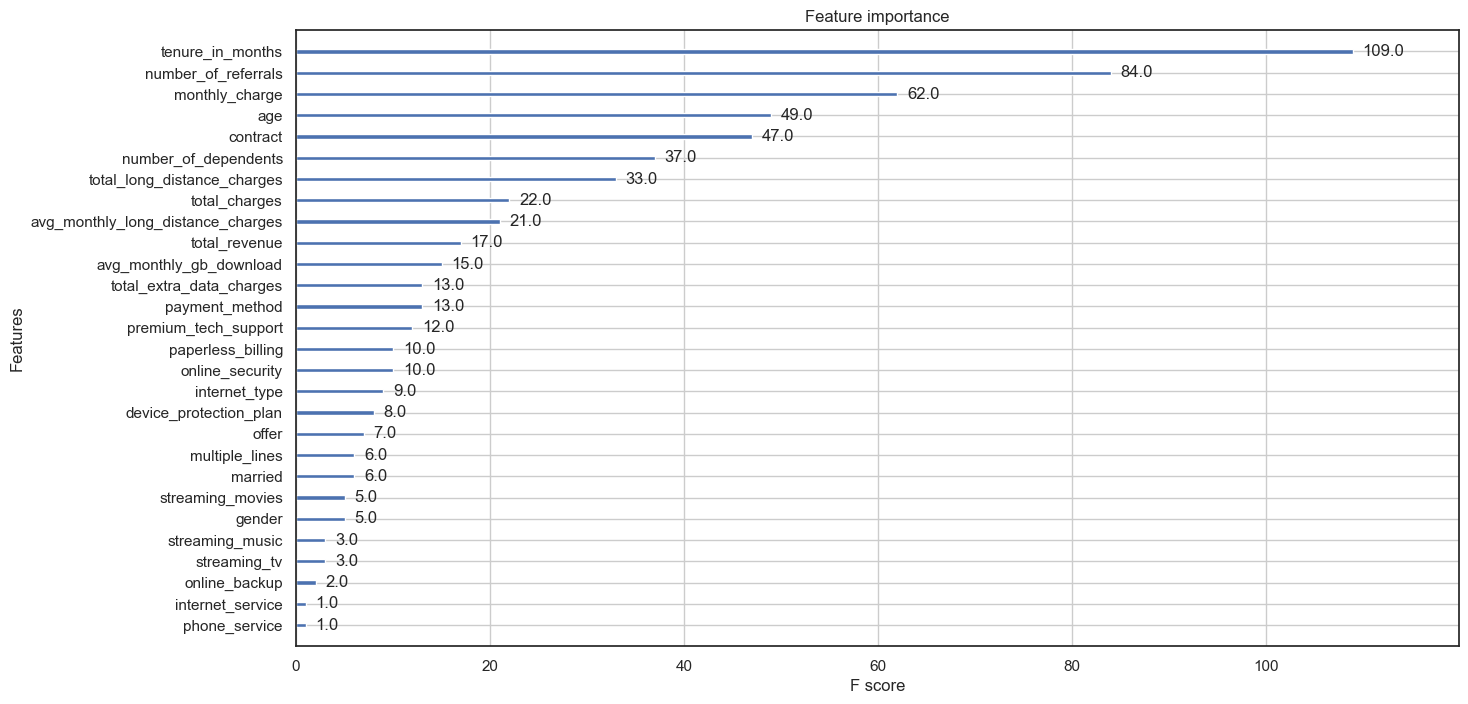

In [52]:
# 특성중요도 시각화
fig, ax = plt.subplots(figsize=(15, 8))
plot_importance(good_xgb, ax=ax)

Results on test data
Test accuracy =  0.8503
Test precision =  0.8867
Test recall =  0.9068
Test auc =  0.8072
Classification report:
              precision    recall  f1-score   support

           0       0.75      0.71      0.73       561
           1       0.89      0.91      0.90      1416

    accuracy                           0.85      1977
   macro avg       0.82      0.81      0.81      1977
weighted avg       0.85      0.85      0.85      1977

Confusion matrix (Rows actual, Columns predicted):
     0     1
0  397   164
1  132  1284

ROC curve


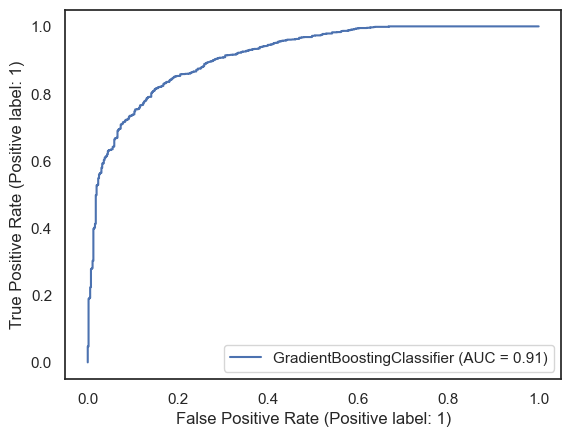

In [53]:
# base_features= ['age','number_of_dependents', 'number_of_referrals', 'tenure_in_months', 'avg_monthly_long_distance_charges',
#                'avg_monthly_gb_download','online_security', 'online_backup',
#                'premium_tech_support', 'unlimited_data', 'contract', 'paperless_billing',
#                'payment_method', 'monthly_charge', 'total_charges', 'total_long_distance_charges', 'total_revenue']
# X2 = prc2[base_features]
# y2 = prc2.churn
prc2 = pd.read_csv('./ft_imp.csv')
X2 = prc2.drop(['churn'], axis=1)
y2 = prc2['churn']
train_X2, val_X2, train_y2, val_y2 = train_test_split(X2, y2, test_size=0.3, random_state = 42)
good_modelGB = good_gb.fit(train_X2, train_y2)

imp_features = ['contract', 'tenure_in_months', 'monthly_charge', 'number_of_referrals']

good_modelGB.fit(X_train[imp_features], y_train) # train model
pred = good_modelGB.predict(X_test[imp_features]) # predicted output for test examples
print("Results on test data")
acc = accuracy_score(y_test, pred) # accuracy on test examples
pre = precision_score(y_test, pred) # precision on test examples
rec = recall_score(y_test, pred) # recall on test examples
auc = roc_auc_score(y_test, pred) # roc_auc on test examples

print(f'Test accuracy = {acc: .4f}') # round to 4 decimal places
print(f'Test precision = {pre: .4f}') # round to 4 decimal places
print(f'Test recall = {rec: .4f}') # round to 4 decimal places
print(f'Test auc = {auc: .4f}')

print("Classification report:")
print(classification_report(y_test, pred))

print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(y_test, pred)))

print('\nROC curve')
RocCurveDisplay.from_estimator(good_modelGB, X_test[imp_features], y_test)
plt.show()

## 5-3. Model Evaluating using Feature Importances (LGBM)

In [54]:
perm = PermutationImportance(good_lgbm, random_state = 1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0980 ± 0.0080,tenure_in_months
0.0459 ± 0.0093,contract
0.0367 ± 0.0103,number_of_referrals
0.0258 ± 0.0109,monthly_charge
0.0150 ± 0.0048,number_of_dependents
0.0136 ± 0.0055,age
0.0026 ± 0.0037,premium_tech_support
0.0015 ± 0.0017,internet_type
0.0014 ± 0.0012,streaming_music
0.0010 ± 0.0024,total_revenue


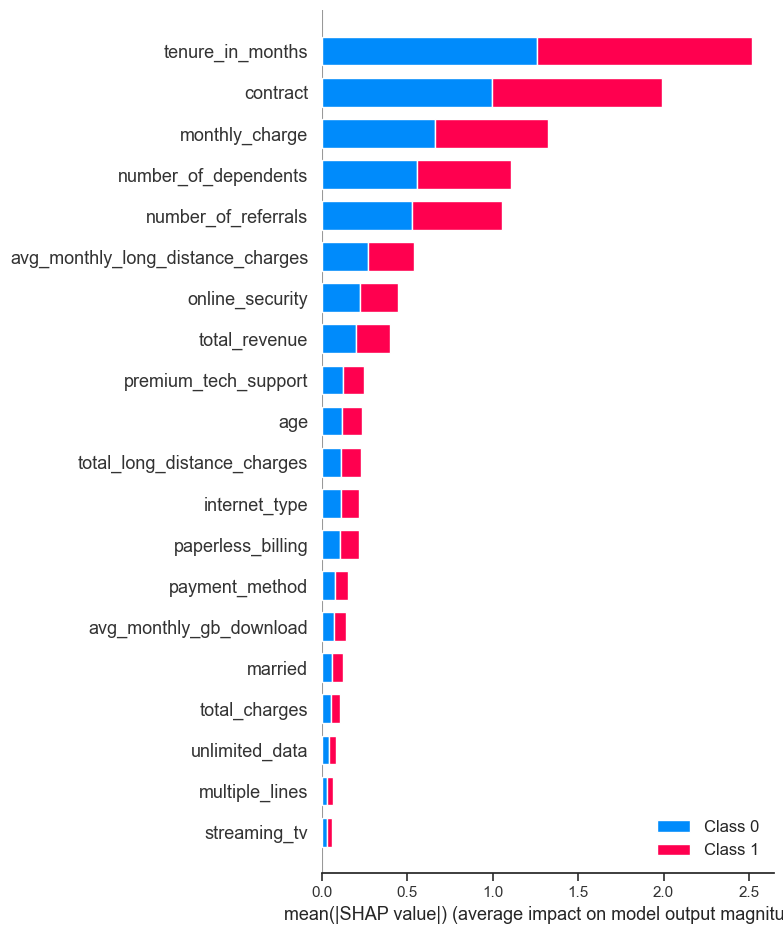

In [55]:
explainer = shap.TreeExplainer(good_lgbm)
shap_values = explainer.shap_values(X)
plt.figure(figsize=(10, 5))
shap.summary_plot(shap_values, X_train)
plt.show()

In [63]:
prc2 = pd.read_csv('./ft_imp.csv')
prc2.columns
prc2.drop(['Unnamed: 0'],axis=1)

,gender,age,married,number_of_dependents,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,multiple_lines,...,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_extra_data_charges,total_long_distance_charges,total_revenue,tenure_in_years,churn
0,0,37,1,0,2,9,0,1,42.390000,0,...,1,1,1,65.60,593.30,0,381.51,974.81,1,1
1,1,46,0,0,0,9,0,1,10.690000,2,...,0,0,1,-4.00,542.40,10,96.21,610.28,1,1
2,1,50,0,0,0,4,5,1,33.650000,0,...,0,1,0,73.90,280.85,0,134.60,415.45,1,0
3,1,78,1,0,1,13,4,1,27.820000,0,...,0,1,0,98.00,1237.85,0,361.66,1599.51,2,0
4,0,75,1,0,3,3,0,1,7.380000,0,...,0,1,1,83.90,267.40,0,22.14,289.54,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6584,0,36,0,0,0,4,0,1,2.010000,0,...,0,0,0,20.95,85.50,0,8.04,93.54,1,0
6585,0,20,0,0,0,13,4,1,46.680000,0,...,1,0,1,55.15,742.90,0,606.84,1349.74,2,1
6586,1,40,1,0,1,22,4,1,16.200000,2,...,0,1,0,85.10,1873.70,0,356.40,2230.10,2,0
6587,1,21,1,0,5,67,1,1,2.120000,0,...,2,0,1,67.85,4627.65,0,142.04,4769.69,6,1


In [73]:
print(lgb.__version__)

3.3.5


In [74]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

prc2 = pd.read_csv('./ft_imp.csv')
X2 = prc2.drop(['churn'], axis=1)
y2 = prc2['churn']
train_X2, val_X2, train_y2, val_y2 = train_test_split(X2, y2, random_state=42)

imp_features = ['contract', 'tenure_in_months', 'monthly_charge', 'number_of_referrals', 'age',
               'number_of_dependents']

# 특수 문자 대체
imp_features = [feature.replace('/', '_') for feature in imp_features]

# 열 이름을 포함한 데이터프레임 생성
train_X2 = train_X2[imp_features]
val_X2 = val_X2[imp_features]

final_lgbm = lgb.LGBMClassifier()
final_lgbm.fit(train_X2, train_y2)
predLGBM = final_lgbm.predict(val_X2)

print("Results on test data")
accLGBM = accuracy_score(val_y2, predLGBM)
preLGBM = precision_score(val_y2, predLGBM)
recLGBM = recall_score(val_y2, predLGBM)
aucLGBM = roc_auc_score(val_y2, predLGBM)
print(f'Test accuracy = {accLGBM:.4f}')
print(f'Test precision = {preLGBM:.4f}')
print(f'Test recall = {recLGBM:.4f}')
print(f'Test roc_auc = {aucLGBM:.4f}')

print("Classification report:")
print(classification_report(val_y2, predLGBM))
print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(val_y2, predLGBM)))


Results on test data
Test accuracy = 0.8617
Test precision = 0.8779
Test recall = 0.9350
Test roc_auc = 0.8088
Classification report:
              precision    recall  f1-score   support

           0       0.81      0.68      0.74       479
           1       0.88      0.93      0.91      1169

    accuracy                           0.86      1648
   macro avg       0.84      0.81      0.82      1648
weighted avg       0.86      0.86      0.86      1648

Confusion matrix (Rows actual, Columns predicted):
     0     1
0  327   152
1   76  1093
